In [29]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import joblib


In [3]:
current_dir = os.getcwd()  # Use os.getcwd() to get the current working directory
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, "data")
file_path = os.path.join(data_dir, "")
csv_path = os.path.join(data_dir, "bodyPerformance.csv")
df_model = pd.read_csv(csv_path)

In [4]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      13393 non-null  float64
 1   gender                   13393 non-null  object 
 2   height_cm                13393 non-null  float64
 3   weight_kg                13393 non-null  float64
 4   body fat_%               13393 non-null  float64
 5   diastolic                13393 non-null  float64
 6   systolic                 13393 non-null  float64
 7   gripForce                13393 non-null  float64
 8   sit and bend forward_cm  13393 non-null  float64
 9   sit-ups counts           13393 non-null  float64
 10  broad jump_cm            13393 non-null  float64
 11  class                    13393 non-null  object 
dtypes: float64(10), object(2)
memory usage: 1.2+ MB


In [5]:
conteo_clases = df_model.value_counts()
print(conteo_clases)

age   gender  height_cm  weight_kg  body fat_%  diastolic  systolic  gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm  class
27.0  F       157.0      49.1       30.7        70.0       86.0      27.7       19.7                     51.0            167.0          A        2
64.0  M       172.0      67.9       15.9        76.0       135.0     34.3       22.5                     51.0            186.0          A        1
              170.7      62.2       20.3        78.0       117.0     38.8       16.4                     19.0            200.0          C        1
21.0  F       154.6      54.8       35.2        78.0       116.0     24.4       25.5                     44.0            155.0          A        1
64.0  M       183.5      75.4       17.2        80.0       143.0     46.5       21.0                     34.0            188.0          A        1
                                                                                                                           

In [6]:
df_model['class'].value_counts(normalize=True)  
df_model['class'].value_counts()               

class
C    3349
D    3349
A    3348
B    3347
Name: count, dtype: int64

Perfectamente balanceado, no necesitamos aplicar técnicas de balanceado.

Vamos a empezar a probar con modelos.

In [7]:
print(df_model['gender'].unique())

['M' 'F']


In [8]:
print(df_model['gender'].value_counts(normalize=True))

gender
M    0.632196
F    0.367804
Name: proportion, dtype: float64


Podría haber un sesgo en el modelo porque hay casi el doble de hombres??

In [30]:
gender_map = {'M': 0, 'F': 1}

joblib.dump(gender_map, 'gender_map.pkl')

['gender_map.pkl']

In [10]:
print(df_model['gender'].unique())       
print(df_model['gender'].value_counts()) 


[0 1]
gender
0    8467
1    4926
Name: count, dtype: int64


In [31]:
class_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
joblib.dump(class_map, 'class_map.pkl')

['class_map.pkl']

In [32]:
print(df_model['class'].unique())       
print(df_model['class'].value_counts()) 

[2 0 1 3]
class
2    3349
3    3349
0    3348
1    3347
Name: count, dtype: int64


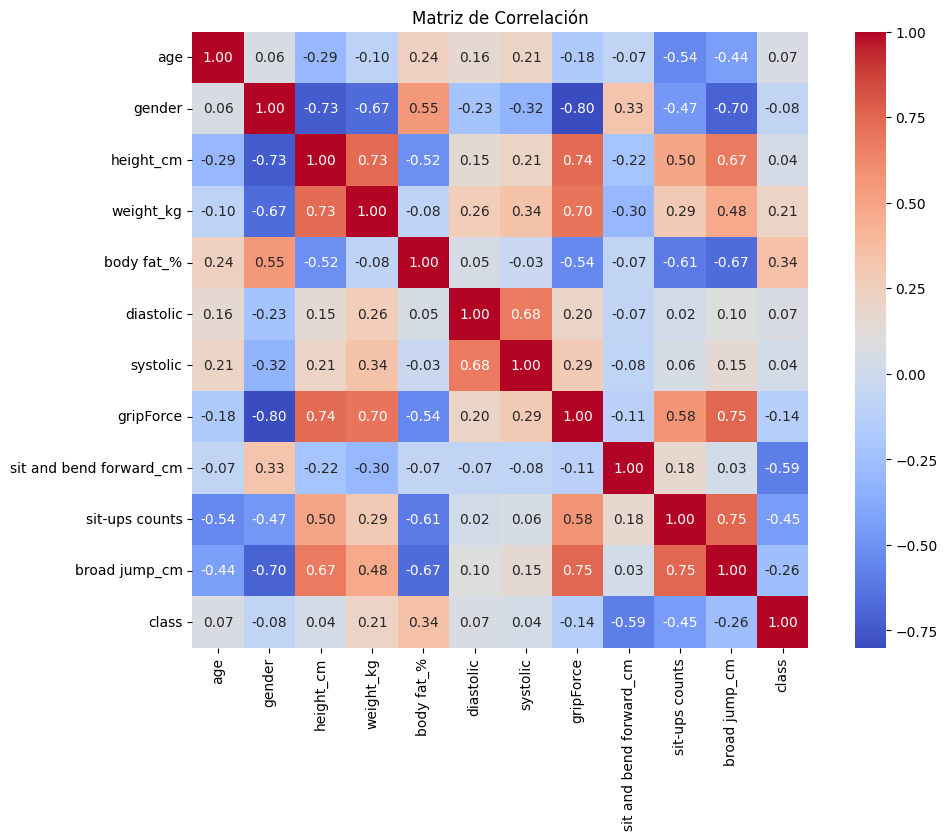

In [13]:
corr_matrix = df_model.corr(numeric_only=True)

# Mostrar como heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlación")
plt.show()

In [14]:
pd.crosstab(df_model['class'], df_model['gender'], normalize='index')  # distribución de género dentro de cada clase


gender,0,1
class,,
0,0.556750,0.443250
1,0.645952,0.354048
2,0.667961,0.332039
3,0.658107,0.341893


In [15]:
X = df_model.drop(columns=['class'])
y = df_model['class']
print(X.shape)

(13393, 11)


Dividimos entre entrenamiento y prueba:

In [16]:
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=42)

Probamos con XGBoost

In [17]:
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb.fit(XTrain, yTrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

Predicción:

In [18]:
yPred = xgb.predict(XTest)
print("Accuracy:", accuracy_score(yTest, yPred))

Accuracy: 0.7655841731989549


Búsqueda de hiperparámetros: 

In [20]:
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(XTrain, yTrain)

print("Mejores parámetros:", random_search.best_params_)

best_model = random_search.best_estimator_
y_pred_best = best_model.predict(XTest)
print("Accuracy tras búsqueda:", accuracy_score(yTest, y_pred_best))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores parámetros: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Accuracy tras búsqueda: 0.7670772676371781


In [22]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

modelos = {
    'XGBoost': XGBClassifier(**random_search.best_params_, use_label_encoder=False, eval_metric='mlogloss'),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}


In [23]:
parametros = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, None]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    }
}


In [28]:


modelos = {
    'XGBoost': XGBClassifier(eval_metric='mlogloss', random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}


resultados = []

for nombre, modelo in modelos.items():
    modelo.fit(XTrain, yTrain)
    
    # Predicciones
    y_train_pred = modelo.predict(XTrain)
    y_test_pred = modelo.predict(XTest)
    
    # Métricas
    acc_train = accuracy_score(yTrain, y_train_pred)
    acc_test = accuracy_score(yTest, y_test_pred)
    
    f1_train = f1_score(yTrain, y_train_pred, average='weighted')
    f1_test = f1_score(yTest, y_test_pred, average='weighted')
    
    # Overfitting
    acc_gap = acc_train - acc_test
    f1_gap = f1_train - f1_test
    
    resultados.append({
        'Modelo': nombre,
        'Accuracy (train)': round(acc_train, 4),
        'Accuracy (test)': round(acc_test, 4),
        'Overfitting (acc)': round(acc_gap, 4),
        'F1-score (train)': round(f1_train, 4),
        'F1-score (test)': round(f1_test, 4),
        'Overfitting (f1)': round(f1_gap, 4),
    })

df_resultados = pd.DataFrame(resultados)
print(df_resultados)


              Modelo  Accuracy (train)  Accuracy (test)  Overfitting (acc)  \
0            XGBoost            0.9585           0.7656             0.1929   
1      Random Forest            1.0000           0.7451             0.2549   
2  Gradient Boosting            0.7637           0.7283             0.0354   

   F1-score (train)  F1-score (test)  Overfitting (f1)  
0            0.9586           0.7659            0.1927  
1            1.0000           0.7451            0.2549  
2            0.7632           0.7282            0.0350  


Gradient Boosting sacrifica un poco de accuracy, pero generaliza mejor. Es un buen punto de partida.